In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
from copy import deepcopy
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. Feature Extraction with a Pretrained Model

In [3]:
preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.223, 0.224, 0.225])
])
BATCH_SIZE = 64

In [4]:
# Dataset for Feature Extraction
train_data = datasets.CIFAR10(root='./images/CIFAR-10', train = True, download = True, transform = preprocessing)
test_data = datasets.CIFAR10(root='./images/CIFAR-10', train = False, download = True, transform = preprocessing)
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

### 1.a) Extracting Features from the Feature Model

In [5]:
# Feature Model
feature_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in feature_model.parameters():
    param.requires_grad = False
feature_model.fc = nn.Identity()
feature_model = feature_model.to(device)

In [41]:
def get_features(model, dataLoader):
    model.eval()
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for img, label in tqdm(dataLoader):
            img = img.to(device)

            output = model(img)
            features_list.append(output.cpu())
            labels_list.append(label)
    
    features = torch.cat(features_list)
    labels = torch.cat(labels_list)
    return features, labels

In [ ]:
train_features_cifar10, train_labels_cifar10 = get_features(feature_model, train_loader)
print(f""""Train Feature Extraction Completed | Train_features Shape: {train_features_cifar10.shape}""")
test_features_cifar10, test_labels_cifar10 = get_features(feature_model, test_loader)
print(f""""Test Feature Extraction Completed  | Test_features Shape: {test_features_cifar10.shape}""")

100%|██████████| 782/782 [03:38<00:00,  3.58it/s]


"Train Feature Extraction Completed | Train_features Shape: torch.Size([50000, 2048])


100%|██████████| 157/157 [00:43<00:00,  3.62it/s]

"Test Feature Extraction Completed  | Test_features Shape: torch.Size([10000, 2048])


In [ ]:
# # Save the feature data
# train_feature_cifar10_data = {'features': train_features_cifar10, 'label': train_labels_cifar10}
# test_feature_cifar10_data = {'features': test_features_cifar10, 'label': test_labels_cifar10}
# torch.save(train_feature_cifar10_data, 'savedData/train_features_cifar10.pt')
# torch.save(test_feature_cifar10_data, 'savedData/test_features_cifar10.pt')

# # Load the feature data
# train_feature_cifar10_data = torch.load('savedData/train_features_cifar10.pt')
# test_feature_cifar10_data = torch.load('savedData/test_features_cifar10.pt')
# train_features_cifar10, train_labels_cifar10 = train_feature_cifar10_data['features'], train_feature_cifar10_data['label']
# test_features_cifar10, test_labels_cifar10 = test_feature_cifar10_data['features'], test_feature_cifar10_data['label']

### 1.b) Training a simple classifier on these extracted features

In [17]:
BATCH_SIZE = 64

In [ ]:
# Creating new dataset based on extracted features
train_feature_dataset = TensorDataset(train_features_cifar10, train_labels_cifar10)
test_feature_dataset = TensorDataset(test_features_cifar10, test_labels_cifar10)

# Creating dataLoader for this new dataset
train_features_loader = DataLoader(train_feature_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_features_loader = DataLoader(test_feature_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
# Creating Simple Classifier Model
num_features = train_features_cifar10.shape[1]
classifier_model = nn.Linear(num_features, 10)
classifier_model = classifier_model.to(device)

In [20]:
# Loss and Gradient
loss_fn = nn.CrossEntropyLoss()                                     # calculates softmax and then loss 
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)     # To update weights

In [31]:
def eval(model, test_dataloader, showProgress = False):
    model.eval()
    correct = 0
    total = 0

    if showProgress:
        bar = tqdm(test_dataloader)
    else:
        bar = test_dataloader

    with torch.no_grad():
        for inp, label in bar:
            inp, label = inp.to(device), label.to(device)
            output = model(inp)
            
            _, predicted = torch.max(output, 1)    # returns maxValue, Index of the maximum logit value
            
            total += label.size(0)
            correct += (predicted == label).sum().item()

    test_acc = correct / total
    return test_acc

In [22]:
def train(model, optimizer, loss_fn, train_dataloader, num_epochs, test_per_epoch = False, test_dataloader = None):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        # To train mode
        model.train()
        cum_loss = 0.0
        correct = 0
        total = 0

        # Bar Visualizer
        bar = tqdm(train_dataloader)

        for inp, label in bar:
            # for cuda
            inp, label = inp.to(device), label.to(device)
            
            # initializing zero gradient matrix
            optimizer.zero_grad()
            
            # Forward pass
            output = model(inp)                     # returns logits (batch_size x classes) matrix
            loss = loss_fn(output, label)           # Calculates average loss of the batch
            
            _, predicted = torch.max(output, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            # Backward Pass
            loss.backward()        # calculates the gradient
            optimizer.step()       # calculates the new weights

            cum_loss += loss.item() * inp.size(0)  # Calculating Cumulative loss for all the batches
        
        epoch_loss = cum_loss / len(train_features_loader.dataset)   # Average Loss per epoch
        train_loss_list.append(epoch_loss)
        train_acc = correct / total
        train_acc_list.append(train_acc)

        if test_per_epoch:
            test_acc = eval(model, test_dataloader)
            test_acc_list.append(test_acc)
            print(f"""Epoch: {epoch + 1}/{num_epochs} | Train Loss: {epoch_loss:.3f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}""")
        else:
            print(f"""Epoch: {epoch + 1}/{num_epochs} | Train Loss: {epoch_loss:.3f} | Train Acc: {train_acc:.3f}""")
    return (train_loss_list, train_acc_list, test_acc_list)

In [23]:
train_loss_list, train_acc_list, test_acc_list = train(classifier_model, optimizer, loss_fn, train_features_loader, 30, True, test_features_loader)

100%|██████████| 782/782 [00:01<00:00, 470.59it/s]


Epoch: 1/30 | Train Loss: 0.835 | Train Acc: 0.737 | Test Acc: 0.781


100%|██████████| 782/782 [00:01<00:00, 565.99it/s]


Epoch: 2/30 | Train Loss: 0.595 | Train Acc: 0.803 | Test Acc: 0.795


100%|██████████| 782/782 [00:01<00:00, 531.41it/s]


Epoch: 3/30 | Train Loss: 0.534 | Train Acc: 0.821 | Test Acc: 0.801


100%|██████████| 782/782 [00:01<00:00, 508.24it/s]


Epoch: 4/30 | Train Loss: 0.498 | Train Acc: 0.833 | Test Acc: 0.804


100%|██████████| 782/782 [00:01<00:00, 477.37it/s]


Epoch: 5/30 | Train Loss: 0.472 | Train Acc: 0.840 | Test Acc: 0.807


100%|██████████| 782/782 [00:01<00:00, 484.94it/s]


Epoch: 6/30 | Train Loss: 0.453 | Train Acc: 0.847 | Test Acc: 0.803


100%|██████████| 782/782 [00:01<00:00, 508.38it/s]


Epoch: 7/30 | Train Loss: 0.437 | Train Acc: 0.853 | Test Acc: 0.807


100%|██████████| 782/782 [00:01<00:00, 510.80it/s]


Epoch: 8/30 | Train Loss: 0.425 | Train Acc: 0.856 | Test Acc: 0.802


100%|██████████| 782/782 [00:01<00:00, 470.85it/s]


Epoch: 9/30 | Train Loss: 0.414 | Train Acc: 0.858 | Test Acc: 0.797


100%|██████████| 782/782 [00:01<00:00, 484.35it/s]


Epoch: 10/30 | Train Loss: 0.405 | Train Acc: 0.862 | Test Acc: 0.802


100%|██████████| 782/782 [00:01<00:00, 508.54it/s]


Epoch: 11/30 | Train Loss: 0.397 | Train Acc: 0.864 | Test Acc: 0.804


100%|██████████| 782/782 [00:01<00:00, 504.18it/s]


Epoch: 12/30 | Train Loss: 0.390 | Train Acc: 0.866 | Test Acc: 0.800


100%|██████████| 782/782 [00:01<00:00, 504.83it/s]


Epoch: 13/30 | Train Loss: 0.383 | Train Acc: 0.870 | Test Acc: 0.799


100%|██████████| 782/782 [00:01<00:00, 518.77it/s]


Epoch: 14/30 | Train Loss: 0.377 | Train Acc: 0.871 | Test Acc: 0.799


100%|██████████| 782/782 [00:01<00:00, 470.80it/s]


Epoch: 15/30 | Train Loss: 0.373 | Train Acc: 0.873 | Test Acc: 0.799


100%|██████████| 782/782 [00:01<00:00, 510.12it/s]


Epoch: 16/30 | Train Loss: 0.368 | Train Acc: 0.875 | Test Acc: 0.793


100%|██████████| 782/782 [00:01<00:00, 476.83it/s]


Epoch: 17/30 | Train Loss: 0.363 | Train Acc: 0.876 | Test Acc: 0.795


100%|██████████| 782/782 [00:01<00:00, 500.93it/s]


Epoch: 18/30 | Train Loss: 0.359 | Train Acc: 0.877 | Test Acc: 0.796


100%|██████████| 782/782 [00:01<00:00, 483.80it/s]


Epoch: 19/30 | Train Loss: 0.356 | Train Acc: 0.877 | Test Acc: 0.794


100%|██████████| 782/782 [00:01<00:00, 526.73it/s]


Epoch: 20/30 | Train Loss: 0.352 | Train Acc: 0.880 | Test Acc: 0.795


100%|██████████| 782/782 [00:01<00:00, 501.66it/s]


Epoch: 21/30 | Train Loss: 0.350 | Train Acc: 0.881 | Test Acc: 0.793


100%|██████████| 782/782 [00:01<00:00, 468.77it/s]


Epoch: 22/30 | Train Loss: 0.347 | Train Acc: 0.881 | Test Acc: 0.793


100%|██████████| 782/782 [00:01<00:00, 521.21it/s]


Epoch: 23/30 | Train Loss: 0.344 | Train Acc: 0.883 | Test Acc: 0.791


100%|██████████| 782/782 [00:01<00:00, 448.49it/s]


Epoch: 24/30 | Train Loss: 0.342 | Train Acc: 0.883 | Test Acc: 0.791


100%|██████████| 782/782 [00:01<00:00, 489.11it/s]


Epoch: 25/30 | Train Loss: 0.340 | Train Acc: 0.882 | Test Acc: 0.792


100%|██████████| 782/782 [00:01<00:00, 537.82it/s]


Epoch: 26/30 | Train Loss: 0.337 | Train Acc: 0.884 | Test Acc: 0.789


100%|██████████| 782/782 [00:01<00:00, 524.52it/s]


Epoch: 27/30 | Train Loss: 0.335 | Train Acc: 0.885 | Test Acc: 0.787


100%|██████████| 782/782 [00:01<00:00, 514.44it/s]


Epoch: 28/30 | Train Loss: 0.333 | Train Acc: 0.886 | Test Acc: 0.784


100%|██████████| 782/782 [00:01<00:00, 508.91it/s]


Epoch: 29/30 | Train Loss: 0.332 | Train Acc: 0.886 | Test Acc: 0.786


100%|██████████| 782/782 [00:01<00:00, 465.40it/s]


Epoch: 30/30 | Train Loss: 0.329 | Train Acc: 0.887 | Test Acc: 0.788


### 1.c) Report Classification Accuracy and Plot the loss curve

In [24]:
print(f"""Classification Accuracy on the Test Data: {test_acc_list[-1] * 100:.2f}% """)

Classification Accuracy on the Test Data: 78.80% 


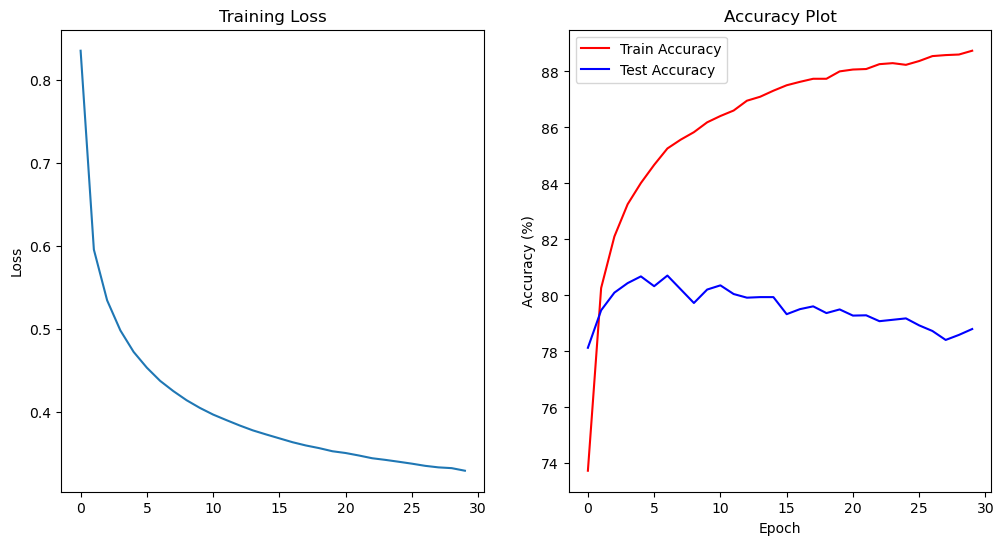

In [25]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize = (12, 6))
axes[0].plot(train_loss_list)
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")

axes[1].plot([x * 100 for x in train_acc_list], color = 'red', label = 'Train Accuracy')
axes[1].plot([x * 100 for x in test_acc_list], color = 'blue', label = 'Test Accuracy')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Accuracy Plot")
axes[1].legend()
plt.show()

# 2. Domain Shift Evaluation and Fine-Tuning

### 2.a) Evaluating the previously trained model on CIFAR-10-C dataset

In [91]:
## IMPORTANT



## Download the CIFAR-10-C dataset before running this from the link 'https://zenodo.org/records/2535967'
## After Downloading it, extract the dataset and put it into the path, './images/[Cifar-10-c fodler here]'

In [26]:
# defining a class for easy access using pytorch's dataloader
class CIFAR10C_DATASET(Dataset):
    def __init__(self, data_path, label_path, transform = None, severity = None):
        full_data = np.load(data_path)
        full_label = np.load(label_path)
        self.transform = transform

        if severity is not None:
            start = (severity - 1) * 10000
            end = start + 10000
            self.data = full_data[start : end]
            self.label = full_label[start : end]
        else:
            self.data = full_data
            self.label = full_label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = Image.fromarray(self.data[index])
        label = self.label[index]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype = torch.long)

        return image, label

In [27]:
# Choose the index of the corruption type from this list, 
# BATCH_SIZE, 
# Severity {1, 2, 3, 4, 5, None}, None for full data
corruption_type = { 0: 'brightness',    1: 'contrast',      2: 'defocus_blur',      3: 'elastic_transform', 
                    4: 'fog',           5: 'frost',         6: 'gaussian_blur',     7: 'gaussian_noise', 
                    8: 'glass_blur',    9: 'impulse_noise', 10: 'jpeg_compression', 11: 'labels', 
                    12: 'motion_blur', 13: 'pixelate',      14: 'saturate',         15: 'shot_noise', 
                    16: 'snow',        17: 'spatter',       18: 'speckle_noise',    19: 'zoom_blur' }
corruption_type_index = 6
severity = None
BATCH_SIZE = 64

data_path = 'images/CIFAR-10-C/' + corruption_type[corruption_type_index] + '.npy'
label_path = 'images/CIFAR-10-C/labels.npy'

In [28]:
# Choose severity from 1 to 5 or None to use full data
cifar_c_dataset = CIFAR10C_DATASET(
    data_path = data_path,
    label_path = label_path,
    transform = preprocessing,
    severity = severity
)
cifar_c_loader = DataLoader(cifar_c_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [29]:
# Merging the classifier with the CNN part of the model
model_full = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model_full.fc = nn.Linear(model_full.fc.in_features, 10)

# Overwriting with the trained parameters
model_full.fc.weight.data = classifier_model.weight.data.cpu()
model_full.fc.bias.data = classifier_model.bias.data.cpu()
model_full = model_full.to(device)

In [ ]:
# Evaluating the original model on CIFAR-10-C dataset
acc = eval(model_full, cifar_c_loader, showProgress = True)

if severity is None:
    print(f"""Accuracy on CIFAR-10-C full dataset is: {acc:.4f} ({acc * 100:.2f})""")
else:
    print(f"""Accuracy on CIFAR-10-C with Severity {severity} is: {acc:.4f} ({acc * 100:.2f})""")

100%|██████████| 782/782 [03:20<00:00,  3.91it/s]

Accuracy on CIFAR-10-C full dataset is: 0.3764 (37.64)


### 2.b) Fine tune the Pre-trained Model

In [33]:
# Creating the small dataset from cifar-10-c dataset
subet_index = np.random.choice(50000, 20000, replace=False)
subset_dataset = Subset(cifar_c_dataset, subet_index)
subset_dataloader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [34]:
# Unfreezing fc and last convolutional block
finetuned_model = deepcopy(model_full)
for param in finetuned_model.parameters():
    param.requires_grad = False

for param in finetuned_model.fc.parameters():
    param.requires_grad = True

for param in finetuned_model.layer4.parameters():
    param.requires_grad = True

In [ ]:
# Defining Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': finetuned_model.layer4.parameters(), 'lr': 0.0001},
    {'params': finetuned_model.fc.parameters(), 'lr': 0.001}
])

In [ ]:
# Fine Tuning the model
train_loss_list, train_acc_list, test_acc_list = train(finetuned_model, optimizer, loss_fn, subset_dataloader, 10)

100%|██████████| 313/313 [01:39<00:00,  3.15it/s]


Epoch: 1/10 | Train Loss: 0.285 | Train Acc: 0.759


100%|██████████| 313/313 [01:41<00:00,  3.08it/s]


Epoch: 2/10 | Train Loss: 0.062 | Train Acc: 0.951


100%|██████████| 313/313 [01:42<00:00,  3.05it/s]


Epoch: 3/10 | Train Loss: 0.019 | Train Acc: 0.989


100%|██████████| 313/313 [01:39<00:00,  3.14it/s]


Epoch: 4/10 | Train Loss: 0.010 | Train Acc: 0.994


100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch: 5/10 | Train Loss: 0.007 | Train Acc: 0.996


100%|██████████| 313/313 [01:41<00:00,  3.08it/s]


Epoch: 6/10 | Train Loss: 0.005 | Train Acc: 0.997


100%|██████████| 313/313 [01:38<00:00,  3.18it/s]


Epoch: 7/10 | Train Loss: 0.004 | Train Acc: 0.998


100%|██████████| 313/313 [01:40<00:00,  3.13it/s]


Epoch: 8/10 | Train Loss: 0.004 | Train Acc: 0.998


100%|██████████| 313/313 [01:39<00:00,  3.16it/s]


Epoch: 9/10 | Train Loss: 0.004 | Train Acc: 0.997


100%|██████████| 313/313 [01:39<00:00,  3.16it/s]

Epoch: 10/10 | Train Loss: 0.004 | Train Acc: 0.998


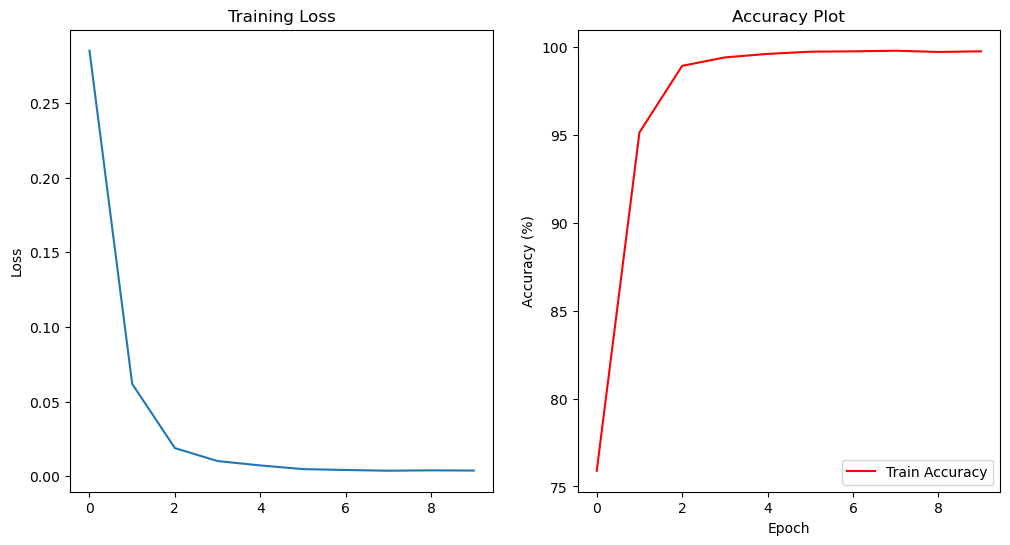

In [87]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize = (12, 6))
axes[0].plot(train_loss_list)
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")

axes[1].plot([x * 100 for x in train_acc_list], color = 'red', label = 'Train Accuracy')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Accuracy Plot")
axes[1].legend()
plt.show()

In [48]:
PATH = 'savedData/resnet50_finetuned.pth'

# # Save the mode
# torch.save(finetuned_model, PATH)

# # Load the model
# finetuned_model = torch.load(PATH)

### 2.c) Evaluate the Fine tuned Model again on the CIFAR-10-C dataset

In [ ]:
# Evaluating the finetuned model on the CIFAR-10-C dataset
acc = eval(finetuned_model, cifar_c_loader, showProgress=True)

if severity is None:
    print(f"""Accuracy on CIFAR-10-C full dataset is: {acc:.4f} ({acc * 100:.2f})""")
else:
    print(f"""Accuracy on CIFAR-10-C with Severity {severity} is: {acc:.4f} ({acc * 100:.2f})""")

100%|██████████| 782/782 [03:19<00:00,  3.92it/s]

Accuracy on CIFAR-10-C full dataset is: 0.9425 (94.25)


In [ ]:
# Evaluated on clean CIFAR-10 test split
acc = eval(finetuned_model, test_loader, showProgress=True)
if severity is None:
    print(f"""Accuracy on CIFAR-10-C full dataset is: {acc:.4f} ({acc * 100:.2f})""")
else:
    print(f"""Accuracy on CIFAR-10-C with Severity {severity} is: {acc:.4f} ({acc * 100:.2f})""")

100%|██████████| 157/157 [00:40<00:00,  3.86it/s]

Accuracy on CIFAR-10-C full dataset is: 0.9079 (90.79)


# 3. Feature Representation Analysis

### 3.a) Extract Features from the Fine-tuned Model

In [43]:
# Removing last FC layer from the Fine_tuned model
finetuned_feature_model = deepcopy(finetuned_model)
for param in finetuned_feature_model.parameters():
    param.requires_grad = False
finetuned_feature_model.fc = nn.Identity()
finetuned_feature_model = finetuned_feature_model.to(device)

In [55]:
finetuned_feature_cifar10c, finetuned_label_cifar10c = get_features(finetuned_feature_model, cifar_c_loader)
feature_cifar10c, label_cifar10c = get_features(feature_model, cifar_c_loader)
finetune_train_feature_cifar10, finetuned_train_label_cifar10 = get_features(finetuned_feature_model, train_loader)
finetune_test_feature_cifar10, finetuned_test_label_cifar10 = get_features(finetuned_feature_model, test_loader)

100%|██████████| 157/157 [00:39<00:00,  4.01it/s]


In [ ]:
# # Save the feature data
# finetune_feature_cifar10c_data = {'features': finetuned_feature_cifar10c, 'label': finetuned_label_cifar10c}
# feature_cifar10c_data = {'features': feature_cifar10c, 'label': label_cifar10c}
# finetune_train_feature_cifar10_data = {'features': finetune_train_feature_cifar10, 'label': finetuned_train_label_cifar10}
# finetune_test_feature_cifar10_data = {'features': finetune_test_feature_cifar10, 'label': finetuned_test_label_cifar10}
# torch.save(finetune_feature_cifar10c_data, 'savedData/finetuned_features_cifar10c.pt')
# torch.save(feature_cifar10c_data, 'savedData/features_cifar10c.pt')
# torch.save(finetune_train_feature_cifar10_data, 'savedData/finetuned_train_features_cifar10.pt')
# torch.save(finetune_test_feature_cifar10_data, 'savedData/finetuned_test_features_cifar10.pt')

# # Load the feature data
# finetuned_feature_cifar10c, finetuned_label_cifar10c = torch.load('savedData/finetuned_features_cifar10c.pt')
# feature_cifar10c, label_cifar10c = torch.load('savedData/features_cifar10c.pt')
# finetune_train_feature_cifar10, finetuned_train_label_cifar10 = torch.load('savedData/finetuned_train_features_cifar10.pt')
# finetune_test_feature_cifar10, finetuned_test_label_cifar10 = torch.load('savedData/finetuned_test_features_cifar10.pt')


### 3.b,c) Use PCA to visualize the features

In [51]:
pca = PCA(n_components = 2)

In [58]:
pca_cifar10_original = pca.fit_transform(train_features_cifar10)
pca_cifar10_finetune = pca.fit_transform(finetune_train_feature_cifar10)

pca_cifar10c_original = pca.fit_transform(feature_cifar10c)
pca_cifar10c_finetune = pca.fit_transform(finetuned_feature_cifar10c)

Text(0, 0.5, 'PC2')

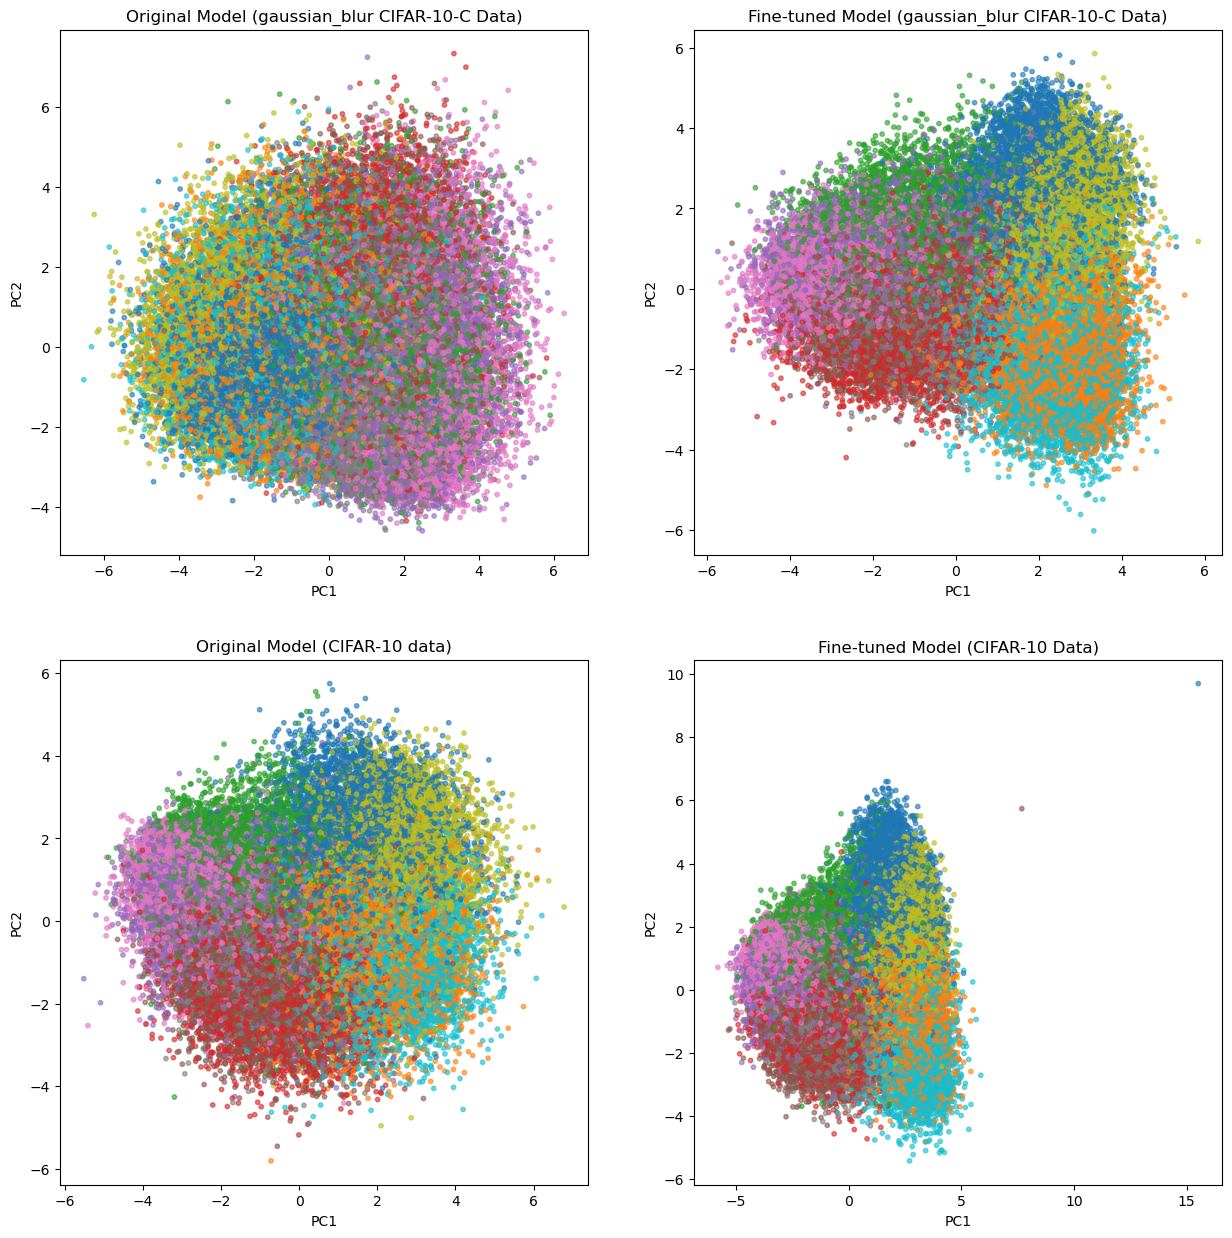

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes[0, 0].scatter(pca_cifar10c_original[:, 0], pca_cifar10c_original[:, 1], c=label_cifar10c, cmap='tab10', alpha=0.6, s=10)
axes[0, 0].set_title(f"""Original Model ({corruption_type[corruption_type_index]} CIFAR-10-C Data)""")
axes[0, 0].set_xlabel("PC1")
axes[0, 0].set_ylabel("PC2")
axes[0, 1].scatter(pca_cifar10c_finetune[:, 0], pca_cifar10c_finetune[:, 1], c=finetuned_label_cifar10c, cmap='tab10', alpha=0.6, s=10)
axes[0, 1].set_title(f"""Fine-tuned Model ({corruption_type[corruption_type_index]} CIFAR-10-C Data)""")
axes[0, 1].set_xlabel("PC1")
axes[0, 1].set_ylabel("PC2")

axes[1, 0].scatter(pca_cifar10_original[:, 0], pca_cifar10_original[:, 1], c=train_labels_cifar10, cmap='tab10', alpha=0.6, s=10 )
axes[1, 0].set_title(f"""Original Model (CIFAR-10 data)""")
axes[1, 0].set_xlabel("PC1")
axes[1, 0].set_ylabel("PC2")
axes[1, 1].scatter(pca_cifar10_finetune[:, 0], pca_cifar10_finetune[:, 1], c=finetuned_train_label_cifar10, cmap='tab10', alpha=0.6, s=10 )
axes[1, 1].set_title(f"""Fine-tuned Model (CIFAR-10 Data)""")
axes[1, 1].set_xlabel("PC1")
axes[1, 1].set_ylabel("PC2")